In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [2]:
vi = 0.01

Vol = vi*10**(-14); NA = 6.02*10**(23); Cal = NA*Vol*10**(-6)

TC = 0.158

kc1 = 0.15*Cal*TC
# production of p53 [molecules/min]

kc2 = 0.1*TC
# degradation of p53 by mdm2 [1/min]

kc3 = 0.1*Cal
# degradation of p53 by mdm2 [molecules]

kc4 = 0.1/Cal*TC
# production of mdm2 - mRNA [1/(molecules*min)]

kc5 = 0.1*TC 
# degradation of mdm2 - mRNA [1/min]

kc6 = 0.2*TC 
# production of mdm2 [1/min]

kc7 = 0.1*TC 
# degradation of mdm2 [1/min]

kc8 = 0.0036 
# binding of mdm2 and nutlin [1/(molecules*min)]

In [3]:
def p_change(t, p, m, Mf, Mb, n):
    dpdt = kc1 - kc2*Mf*(p / (kc3 + p))
    return dpdt

def m_change(t, p, m, Mf, Mb, n):
    dmdt = (kc4 * p**2 - kc5 * m)
    return dmdt

def M_free_change(t, p, m, Mf, Mb, n):
    dM_freedt = kc6 * m - kc7 * Mf - kc8*n*Mf
    return dM_freedt

def M_bound_change(t, p, m, Mf, Mb, n):
    dM_bounddt = - kc7*Mb + kc8*n*Mf
    return dM_bounddt

def n_change(t, p, m, Mf, Mb, n):
    dndt = -kc8*n*Mf
    return dndt

def samlet_system(t, y):
    dydt = np.zeros_like(y)
    dydt[0] = p_change(t, *y)
    dydt[1] = m_change(t, *y)
    dydt[2] = M_free_change(t, *y)
    dydt[3] = M_bound_change(t, *y)
    dydt[4] = n_change(t, *y)
    return dydt

In [4]:
t_samlet = (0, 5000)

p0, m0, Mf0, Mb0, n0 = 100, 1, 1, 1, 1

y0 = [p0, m0, Mf0, Mb0, n0]

In [5]:
samlet_løsning = solve_ivp(samlet_system, t_samlet, y0, method='RK45')
print(samlet_løsning)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  9.698e-02 ...  4.989e+03  5.000e+03]
        y: [[ 1.000e+02  1.001e+02 ...  6.308e+01  6.877e+01]
            [ 1.000e+00  1.253e+00 ...  3.343e+01  3.945e+01]
            ...
            [ 1.000e+00  9.988e-01 ... -7.076e-07 -1.458e-07]
            [ 1.000e+00  9.997e-01 ...  6.556e-07  1.346e-07]]
      sol: None
 t_events: None
 y_events: None
     nfev: 4148
     njev: 0
      nlu: 0


In [6]:
time_transient, p_transient, m_transient, Mf_transient, Mb_transient, n_transient = samlet_løsning["t"], samlet_løsning["y"][0], samlet_løsning["y"][1], samlet_løsning["y"][2], samlet_løsning["y"][3], samlet_løsning["y"][4]

[]

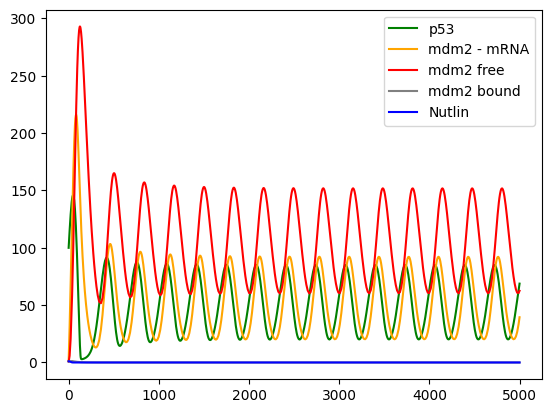

In [7]:
plt.plot(time_transient, p_transient, color="green", label="p53")
plt.plot(time_transient, m_transient, color="orange", label="mdm2 - mRNA")
plt.plot(time_transient, Mf_transient, color="red", label="mdm2 free")
plt.plot(time_transient, Mb_transient, color="gray", label="mdm2 bound")
plt.plot(time_transient, n_transient, color="blue", label="Nutlin")


plt.legend()
plt.plot()

# Peakfinding på transient

"For several conditions the interval borders can be specified with arrays matching x in shape which enables dynamic constrains based on the sample position."

In [8]:
# Compute stats for p53 transient to find period and amplitude for nutlin simulation
def compute_external_oscillator(t, y): #mean, amplitude, period
    y_peaks = find_peaks(y)[0]
    y_troughs = find_peaks(-y)[0]

    # Only keep peaks after the 10 first peaks. We assume that the period and amplitude will be approx. stable after this.
    stable_peaks = None
    stable_troughs = None
    if len(y_peaks) > 12 and len(y_peaks) > len(y_troughs):
        stable_peaks = y_peaks[10:-2]
        stable_troughs = y_troughs[10:-1]
    else:
        stable_peaks = y_peaks[10:-1]
        stable_troughs = y_troughs[10:-1]
        
    # Is it true that N is larger when using troughs also? So that the uncertainty is smaller?
    period = np.mean((np.diff(t[stable_peaks]) + np.diff(t[stable_troughs]))/2)
    # TODO: Calculate uncertainty for this!
    
    amplitude = np.mean((y[stable_peaks] - y[stable_troughs])/2)

    mean_value = np.mean(np.concatenate((y[stable_peaks] - amplitude, y[stable_troughs] + amplitude)))

    return period, amplitude, mean_value, stable_peaks, stable_troughs

In [9]:
T_int, A_int, mean_int, stable_peaks_int, stable_troughs_int = compute_external_oscillator(time_transient, p_transient)

Text(0.5, 1.0, 'Oscillationer af p53 koncentration med perioden T = 329.1 [min]')

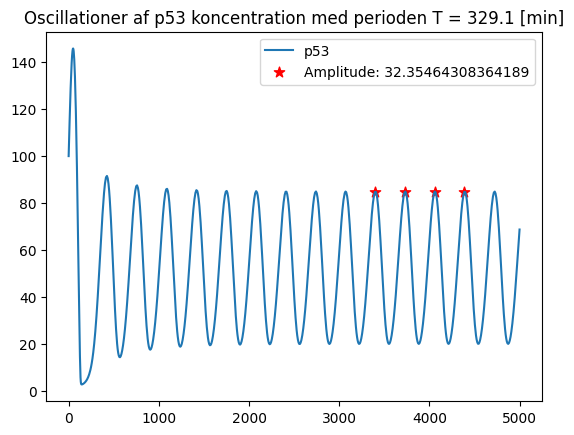

In [10]:
plt.plot(time_transient, p_transient, label="p53")
plt.scatter(time_transient[stable_peaks_int], p_transient[stable_peaks_int], s=60, c="red", marker='*', label=f"Amplitude: {A_int}")

plt.legend()

plt.title(f"Oscillationer af p53 koncentration med perioden T = {T_int:.4} [min]")

In [11]:
def sim_onoff_nutlin(oscillationer, T_int, OOmega, p0, m0, Mf0, Mb0, A_ext):
    # This is correct, and it is working! Remember to count in period values, not frequency! If you count in frequency, you are counting the reciprocal.
    T_ext = OOmega * T_int
    omega = T_int / T_ext

    history = {"t":[] ,"p": [], "m": [], "Mf": [], "Mb":[], "n":[]}

    # TODO: Undersøg max_step i fremtiden
    for i in range(oscillationer):
        if i == 0:
            state = p0, m0, Mf0, Mb0, A_ext
            sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5, dense_output=True)
            t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
            history["t"].extend(t)
            history["p"].extend(p)
            history["m"].extend(m)
            history["Mf"].extend(Mf)
            history["Mb"].extend(Mb)
            history["n"].extend(n)
        
        # Every period, Nutlin concentration is reset to A_ext
        state = history["p"][-1], history["m"][-1], history["Mf"][-1], history["Mb"][-1], A_ext
        sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5, dense_output=True)
        t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
        history["t"].extend(t + history["t"][-1])
        history["p"].extend(p)
        history["m"].extend(m)
        history["Mf"].extend(Mf)
        history["Mb"].extend(Mb)
        history["n"].extend(n)
    
    return history, omega, T_ext

# Simulér med nutlin

In [114]:
current_omega = 5
Nutlin_A = A_int*3

In [115]:
nutlin_sim1, omega, T_ext_sim1 = sim_onoff_nutlin(100, T_int, current_omega, p_transient[-1], m_transient[-1], Mf_transient[-1], Mb_transient[-1], Nutlin_A)

In [116]:
t_1, p_1, m_1, Mb_1, Mf_1, n_1 = np.array(nutlin_sim1["t"]), np.array(nutlin_sim1["p"]), np.array(nutlin_sim1["m"]), np.array(nutlin_sim1["Mb"]), np.array(nutlin_sim1["Mf"]), np.array(nutlin_sim1["n"])

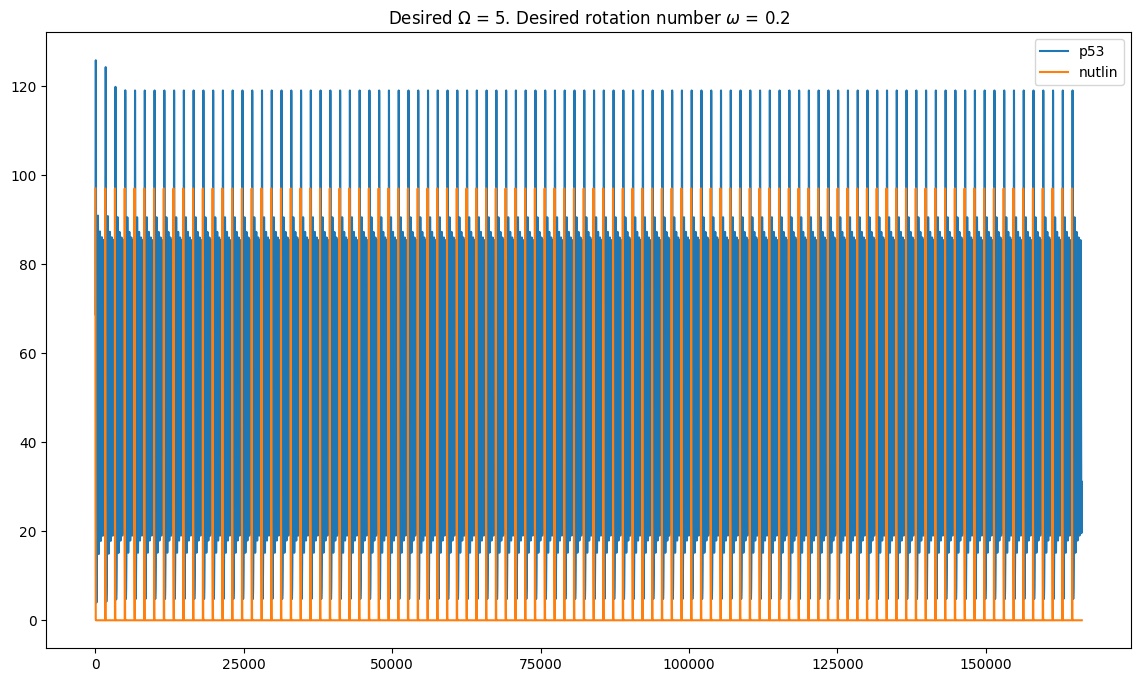

In [117]:
plt.figure(figsize=(14, 8))

plt.plot(t_1, p_1, label="p53")
plt.plot(t_1, n_1, label="nutlin")
# plt.plot(t_1, m_1, label="mRNA")
# plt.plot(t_1, Mb_1, label="Mb")
# plt.plot(t_1, Mf_1, label="Mf")

plt.title(rf"Desired $\Omega$ = {current_omega}. Desired rotation number $\omega$ = {omega:.4}")

plt.legend()

# plt.title(f"Oscillationer af p53 koncentration med perioden T = {period:.4} [min]")

[]

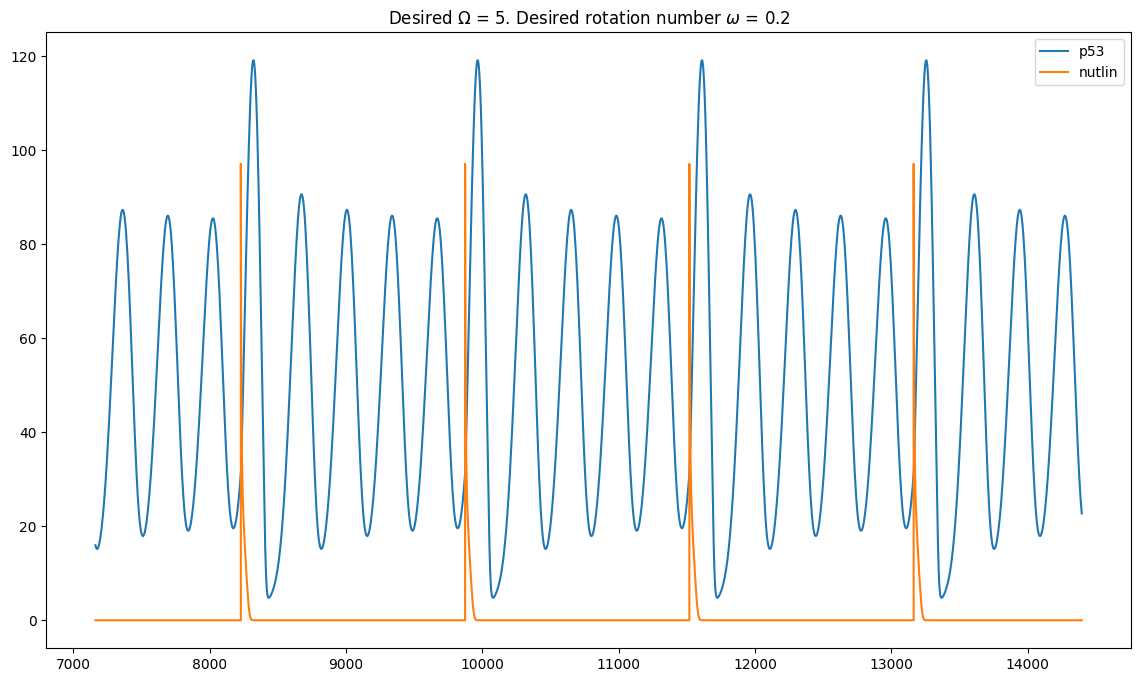

In [118]:
plt.figure(figsize=(14, 8))

plt.plot(t_1[1500:3000], p_1[1500:3000], label="p53")
plt.plot(t_1[1500:3000], n_1[1500:3000], label="nutlin")

# for i in range(len(peaks_nutlin)):
#     plt.scatter(t_1[peaks_nutlin[i]], n_1[peaks_nutlin[i]], c="red", marker='*')

# for i in range(len(troughs_p53)):
#     plt.scatter(t_1[troughs_p53[i]], p_1[troughs_p53[i]], c="black", marker='*')

plt.title(rf"Desired $\Omega$ = {current_omega}. Desired rotation number $\omega$ = {omega:.4}")

plt.legend()
plt.plot()

In [119]:
_, _, _, all_p53_peaks_after_adding_nutlin, _ = compute_external_oscillator(np.array(t_1), np.array(p_1))

[]

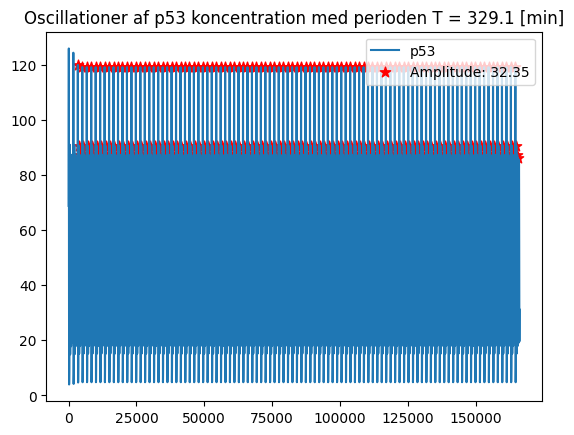

In [139]:
plt.plot(t_1, p_1, label="p53")
plt.scatter(t_1[all_p53_peaks_after_adding_nutlin], p_1[all_p53_peaks_after_adding_nutlin], s=60, c="red", marker='*', label=f"Amplitude: {A_int:.4}")

plt.legend()

plt.title(f"Oscillationer af p53 koncentration med perioden T = {T_int:.4} [min]")
plt.plot()

# Isolér højeste peaks i nutlin sim
Nedenstående er et forsøg på at klassificere entrainment hvor vi kun kigger på de højeste peaks. Men det er svært at isolere peaks'ne consistent uden at miste information.

In [140]:
# Running this after starting nutlin
# For finding a candidate for peak height of highest peaks.
def get_peak_height(y):
    y_peaks = find_peaks(y, height=None)[0][20:40]
    reference_height = 0

    for peak in y_peaks:
        if y[peak] > reference_height:
            reference_height = y[peak]
        else:
            continue
        
    return y_peaks, reference_height

In [141]:
highest_peak_candidates, height_interval = get_peak_height(p_1)

In [145]:
# Use "get_peak_height" after running nutlin sim to get a feeling for where the highest peaks are after adding nutlin
def find_highest_peaks_nutlin(y, reference_height):
    height_interval = [reference_height * 0.93, reference_height * 1.07]

    y_peaks = find_peaks(y, height=height_interval)[0]

    return y_peaks

In [146]:
top_peaks_after_adding_nutlin = find_highest_peaks_nutlin(p_1, height_interval)

Text(0.5, 1.0, 'Oscillationer af p53 koncentration med perioden T = 329.1 [min]')

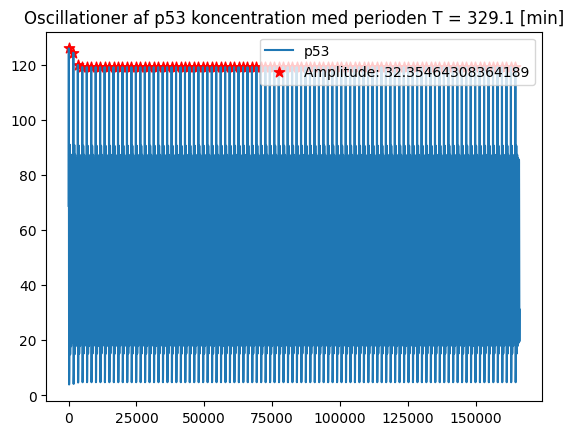

In [147]:
plt.plot(t_1, p_1, label="p53")
plt.scatter(t_1[top_peaks_after_adding_nutlin], p_1[top_peaks_after_adding_nutlin], s=60, c="red", marker='*', label=f"Amplitude: {A_int}")

plt.legend()

plt.title(f"Oscillationer af p53 koncentration med perioden T = {T_int:.4} [min]")

In [148]:
def check_period_convergence(t, peaks):
    period_spacing = np.diff(np.diff(t[peaks]))
    return period_spacing

In [149]:
period_convergence = check_period_convergence(t_1, top_peaks_after_adding_nutlin)

In [150]:
period_convergence

array([-1.54684419e+01, -1.31044558e+00, -3.52134052e+00, -9.45674140e-03,
       -3.11178534e-04, -7.58971328e-06, -1.23487553e-07, -8.36735126e-11,
        8.91304808e-11,  3.63797881e-12,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  7.27595761e-12,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [151]:
x_dummy = np.arange(len(period_convergence))

Text(0.5, 1.0, 'Variation i periode?')

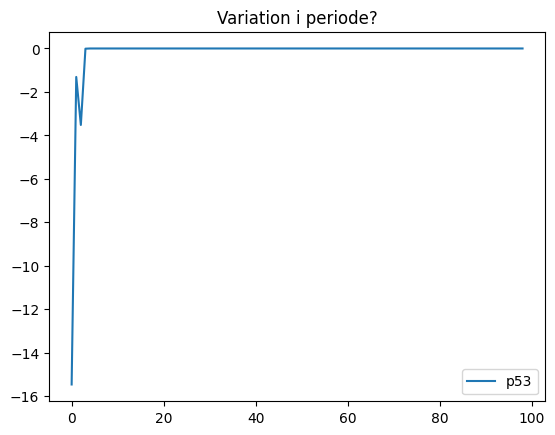

In [152]:
plt.plot(x_dummy, period_convergence, label=r"p53")

plt.legend()

plt.title(f"Variation i periode?")

# Behold mange peaks med nutlin og prøv at kigge på konvergens af alle "serier"

In [286]:
def sort_and_split_peak_series(t, y, threshold):
    """
    Takes the array of p53 values at the peaks found by our own implementation of "find_peaks" (see above)
    Computes the difference between succesive elements.
    Adds a small epsilon value to avoid division by zero (maybe this could be smaller or should be larger)
    Calculates the ratio between successive elements using a mask and takes the absolute value (this is for a scale invariant measure of difference)
    Calculate number of qualitatively different oscillations levels to use for division of period later.
    Selects the lastmost peak array index where the peak-ratios "splits" (i.e. is above the threshold. This is arbritary and might need to be changed).
    Finds the corresponding indeces in the original peak p53 array that corresponds to the sorted peak indices (this means, we should only select the top-most peak series, regardless of scale).
    """
    t_after_transient = t[t > 5000]
    indices_after_transient = np.where(t > 5000)[0]
    y_after_transient = y[indices_after_transient]

    _, _, _, all_y_peaks, _ = compute_external_oscillator(np.array(t_after_transient), np.array(y_after_transient))
    
    sorted = np.sort(y_after_transient[all_y_peaks])

    diff = np.diff(sorted)

    epsilon = 1e-10
    shifted_diff = diff + epsilon
    
    ratio = abs(shifted_diff[1:]/shifted_diff[:-1])

    no_of_series = len(np.where(ratio > threshold)[0]) + 1

    last = np.where(ratio > threshold)
    
    last_split_index = np.where(ratio > threshold)[0][-1] + 2 # Is this always the last one? It seems we need +2 because the index gets shifted twice. One by diff, one by ratio
    print(last)
    
    y_peaks = np.where(np.isin(y_after_transient, sorted[last_split_index:]))[0]

    return y_peaks, no_of_series

In [287]:
p_peaks = sort_and_split_peak_series(t_1, p_1, 1000)[0] # Arbritary size right now of threshold
no_of_p_series = sort_and_split_peak_series(t_1, p_1, 1000)[1] # Arbritary size right now of threshold

(array([ 93, 189, 285, 381]),)
(array([ 93, 189, 285, 381]),)


In [284]:
p_peaks

array([  691,  1033,  1375,  1717,  2059,  2401,  2743,  3085,  3427,
        3769,  4111,  4453,  4795,  5137,  5479,  5821,  6163,  6505,
        6847,  7189,  7531,  7873,  8215,  8557,  8899,  9241,  9583,
        9925, 10267, 10609, 10951, 11293, 11635, 11977, 12319, 12661,
       13003, 13345, 13687, 14029, 14371, 14713, 15055, 15397, 15739,
       16081, 16423, 16765, 17107, 17449, 17791, 18133, 18475, 18817,
       19159, 19501, 19843, 20185, 20527, 20869, 21211, 21553, 21895,
       22237, 22579, 22921, 23263, 23605, 23947, 24289, 24631, 24973,
       25315, 25657, 25999, 26341, 26683, 27025, 27367, 27709, 28051,
       28393, 28735, 29077, 29419, 29761, 30103, 30445, 30787, 31129,
       31471, 31813, 32155, 32497, 32839, 33181])

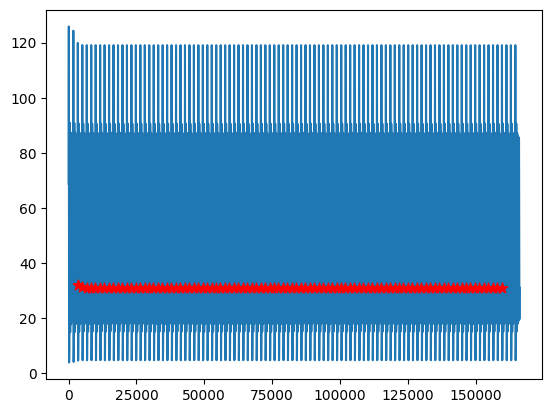

In [285]:
plt.plot(t_1, p_1)
plt.scatter(t_1[p_peaks], p_1[p_peaks], s=60, c="red", marker='*', label=f"Amplitude: {A_int}", zorder=10)

In [226]:
print(t_1[p_peaks], p_1[p_peaks])

[  3291.12666656   4936.68957225   6582.25249333   8227.81541524
   9873.37833717  11518.94125911  13164.50418104  14810.06710298
  16455.63002491  18101.19294685  19746.75586878  21392.31879072
  23037.88171265  24683.44463459  26329.00755652  27974.57047846
  29620.13340039  31265.69632233  32911.25924426  34556.8221662
  36202.38508813  37847.94801007  39493.510932    41139.07385394
  42784.63677587  44430.19969781  46075.76261974  47721.32554168
  49366.88846361  51012.45138555  52658.01430748  54303.57722942
  55949.14015135  57594.70307329  59240.26599522  60885.82891716
  62531.39183909  64176.95476103  65822.51768297  67468.0806049
  69113.64352684  70759.20644877  72404.76937071  74050.33229264
  75695.89521458  77341.45813651  78987.02105845  80632.58398038
  82278.14690232  83923.70982425  85569.27274619  87214.83566812
  88860.39859006  90505.96151199  92151.52443393  93797.08735586
  95442.6502778   97088.21319973  98733.77612167 100379.3390436
 102024.90196554 103670.4648

In [197]:
p_peaks

(array([1741, 2083]), 6)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

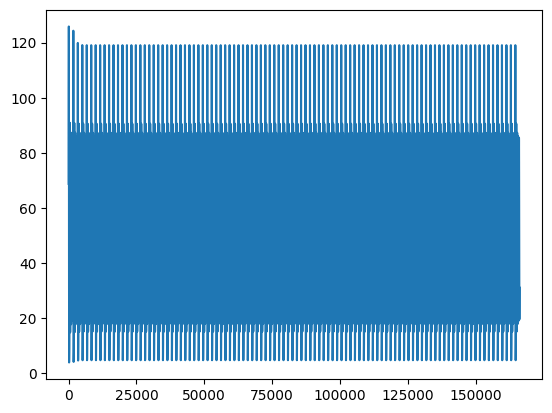

In [196]:
plt.plot(t_1, p_1, label="p53")
plt.scatter(t_1[p_peaks], p_1[p_peaks], s=60, c="red", marker='*', label=f"Amplitude: {A_int}")

plt.legend()

plt.title(f"Oscillationer af p53 koncentration med perioden T = {T_int:.4} [min]")

### Udregn T_ext/T_int

In [110]:
def ext_int_ratio(t, y_peaks, no_of_series, T_ext):
    T_int_arr = np.diff(t[y_peaks]) / no_of_series

    actual_OOmega = T_int_arr/T_ext

    return actual_OOmega

In [112]:
actual_ratio = ext_int_ratio(t_1, p_peaks, no_of_p_series, T_ext_sim1)

In [113]:
print(actual_ratio)

[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.3333

In [411]:
xxs = np.arange(len(actual_ratio))

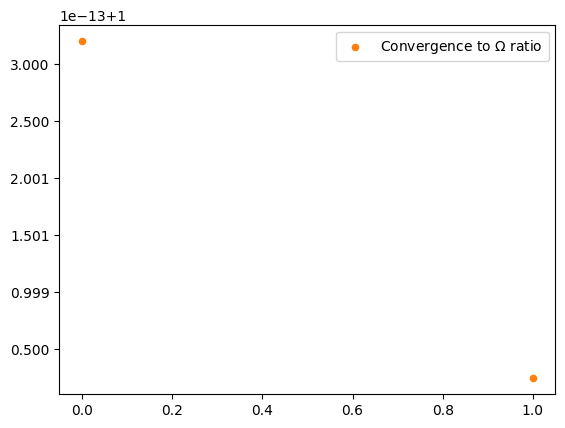

In [412]:
plt.scatter(xxs, actual_ratio, s=20, color="C1", label=r"Convergence to $\Omega$ ratio")
plt.legend()
